# Settings

In [1]:
import pandas as pd
import numpy as np

import matplotlib as plt

import xgboost as xgb

# Read in data

In [3]:
df = pd.read_csv('transformed_version1.csv',index_col=0)

In [4]:
df.head(10)

,id,mood,valence,activity,screen,call,sms,builtin,communication,entertainment,finance,game,office,other,social,travel,unknown,utilities,weather,mood_target
1,AS14.01,7.680000,0.952381,0.087991,91.842770,8.0,5.0,14.594934,48.265692,75.374653,34.024300,166.6525,28.098,11.851621,87.622753,24.126895,30.102,20.644178,0.0,8.0
2,AS14.01,7.600000,0.904762,0.077578,93.990672,10.0,4.0,14.643164,46.611509,66.262493,35.506890,166.6525,28.098,12.523733,113.352526,17.487778,0.000,18.786921,0.0,8.0
3,AS14.01,7.583333,0.909091,0.068845,89.225893,10.0,4.0,16.254677,43.917878,77.735000,36.022983,166.6525,28.098,39.998657,129.032721,17.487778,0.000,18.400463,0.0,7.6
4,AS14.01,7.500000,0.909091,0.103948,114.310741,6.0,4.0,17.396214,47.582145,80.794000,45.660105,166.6525,0.000,41.227294,177.347700,20.672447,3.148,17.520890,0.0,8.0
5,AS14.01,7.375000,0.913043,0.095334,118.324495,7.0,5.0,16.977589,52.419436,85.675873,32.099438,166.6525,0.000,40.149750,169.521795,23.042840,3.148,17.820047,0.0,7.8
6,AS14.01,7.500000,0.920000,0.084697,147.936589,8.0,5.0,9.968315,56.982915,101.219780,34.453714,0.0000,0.000,41.169452,129.813467,22.510500,3.148,18.767680,0.0,7.0
7,AS14.01,7.500000,0.960000,0.090094,137.770328,7.0,5.0,9.207536,56.385226,92.194948,18.421733,0.0000,0.000,40.195710,104.515667,22.510500,3.148,19.618791,0.0,7.6
8,AS14.01,7.480000,0.960000,0.101486,125.296542,9.0,5.0,9.195749,53.605005,71.168160,14.989476,0.0000,0.000,9.353444,98.231415,22.510500,3.148,20.297950,0.0,7.5
9,AS14.01,7.480000,0.960000,0.079984,109.248470,8.0,1.0,12.774524,52.634060,68.444649,16.038900,0.0000,0.000,9.792111,74.432122,20.308667,0.000,21.613467,0.0,7.6
10,AS14.01,7.500000,0.958333,0.073121,109.334349,8.0,2.0,12.602459,53.503023,69.956156,16.332263,0.0000,0.000,8.836231,73.781778,19.910333,0.000,20.702084,0.0,7.2


# Split data

Split dataset into train and test set. 

Distribution is 80% train and 20% test set. In future, validation set can be used to perform grid search, etc.

In [8]:
dataset = df.iloc[:,1:]
rand_split = np.random.rand(len(dataset))
train_list = rand_split < 0.8
#val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.8

data_train = dataset[train_list]
#data_val = dataset[val_list]
data_test = dataset[test_list]

train = xgb.DMatrix(data_train.iloc[:,:-1], label = data_train.iloc[:,-1])
#val = xgb.DMatrix(data_val.iloc[:,1:], label = data_train.iloc[:,0])
test = xgb.DMatrix(data_test.iloc[:,:-1], label = data_test.iloc[:,-1])

In [13]:
data_train.shape

(1010, 19)

# Set parameters

At this moment no parameter grid search or random grid search. Thus, parameter settings are at this moment arbitrary.

In [9]:
param = {
    'max_depth': 5,
    'eta': 0.3,
    'silent': 1,
    'objective': 'reg:linear',
}
param['nthread'] = 4
num_round = 100

# Train model

In [14]:
model = xgb.train(param, train, num_round)

# Evaluate model

Lets look at feature importance. It was expected that mood and valance have much predicting power from correlation plots of pre-processing notebook.

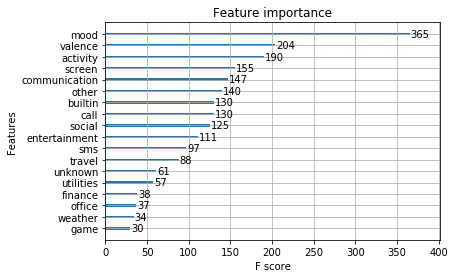

In [35]:
%matplotlib inline
xgb.plot_importance(model)

In [31]:
originals = data_test.iloc[:,-1].values
predictions = model.predict(test)

Calculate some performance metrics. 

Seems to be low. However, no baseline set yet!

In [34]:
import math
MAE = lambda p,o: sum(abs(p - o)) / len(o)
RMSE = lambda p,o: math.sqrt(sum((p - o) ** 2) / len(o))

print('MAE: {}'.format(MAE(predictions, originals)))
print('RMSE: {}'.format(RMSE(predictions, originals)))

MAE: 0.4900792646470908
RMSE: 0.6617289623259621


Thus, lets make a baseline. Every mood is predicted by the average mood of the previous day.

In [45]:
originals = df.iloc[:,-1].values
original = np.delete(originals, originals.shape[0]-1)
prediction = np.delete(originals, 0)

Does not perform much worse. The RMSE is 13.8% worser than xgboost model.

In [46]:
print('MAE: {}'.format(MAE(prediction, original)))
print('RMSE: {}'.format(RMSE(prediction, original)))

MAE: 0.5594823032223984
RMSE: 0.7677261908636778


In [49]:
(1 - 0.6617289623259621/0.7677261908636778) * 100

13.806644842801408